In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime

from dsmanipulator import dsanalyzer as dsa
from dsmanipulator import dsloader as dsl
from dsmanipulator import dscreator as dsc
from dsmanipulator.utils import FileColumnNames

# plt.rc('pgf', texsystem='pdflatex')

In [2]:
fcn=FileColumnNames("TimeStamp", "Relative Time", "srcIP", "dstIP", "srcPort", "dstPort")

filename="../data/10122018-104Mega-ioa.csv"



dialect = dsl.detect_dialect(filename)
df = dsl.load_data(
    filename,
    data_types={
        "TimeStamp": "datetime",
        "Relative Time": "float",
        "srcIP": "object",
        "dstIP": "object",
        "srcPort": "float",
        "dstPort": "float",
        "ipLen": "float",
        "len": "float",
        "fmt": "object",
        "uType": "object",
        "asduType": "float",
        "numix": "float",
        "cot": "float",
        "oa": "float",
        "addr": "float",
        "ioa": "object",
    },
    dialect=dialect,
    row_limit=None
)

dsc.add_relative_days(df, fcn, inplace=True)
station_ids = dsc.create_station_ids(df, fcn)
dsc.add_station_id(df, fcn, station_ids, inplace=True)
pair_ids = dsc.create_pair_ids(df, fcn)
dsc.add_pair_id(df, fcn, pair_ids, inplace=True)
direction_ids = dsc.create_direction_ids(df, fcn)
dsc.add_direction_id(df, fcn, direction_ids, inplace=True)


,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,len,fmt,uType,...,numix,cot,oa,addr,ioa,*Relative Day##,*Source station id##,*Destination station id##,*Pair id##,*Direction id##
0,2022-04-28 13:03:10.310,0.000000,192.168.11.111,192.168.11.248,49784.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,3,2,4
1,2022-04-28 13:03:10.310,0.000595,192.168.11.248,192.168.11.111,2404.0,49784.0,61.0,19.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,3,0,2,2
2,2022-04-28 13:03:10.310,0.000714,192.168.11.111,192.168.11.248,49784.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,3,2,4
3,2022-04-28 13:03:10.310,0.001052,192.168.11.248,192.168.11.111,2404.0,49784.0,62.0,20.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,3,0,2,2
4,2022-04-28 13:03:10.370,0.063226,192.168.11.111,192.168.11.248,49784.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104528,2022-04-28 17:56:31.330,17601.022142,192.168.11.111,192.168.11.248,49849.0,2404.0,46.0,4.0,0x00000001,NaN,...,NaN,NaN,NaN,NaN,NaN,0,2,3,1,1
104529,2022-04-28 17:56:31.330,17601.022612,192.168.11.111,192.168.11.248,49849.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,2,3,1,1
104530,2022-04-28 17:56:31.330,17601.022953,192.168.11.248,192.168.11.111,2404.0,49849.0,60.0,18.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,3,2,1,0
104531,2022-04-28 17:56:31.330,17601.023117,192.168.11.111,192.168.11.248,49849.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,2,3,1,1


In [3]:
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns
from dsmanipulator import dscreator as dsc
from dsmanipulator.utils import Direction, FileColumnNames, Station
from bidict import bidict

def plot_pair_flow(
    df: pd.DataFrame,
    fcn: FileColumnNames,
    axes: Axes,
    pair_id: int,
    station_ids: bidict[int, Station],
    direction_ids: bidict[int, Direction],
    resample_rate: pd.Timedelta,
) -> None:
    assert all(col in df.columns for col in [fcn.timestamp, fcn.pair_id, fcn.direction_id])

    # filter original dataframe and expand values
    # tmpdf = df
    tmpdf = df[df[fcn.pair_id] == pair_id]
    tmpdf = dsc.expand_values_to_columns(tmpdf, fcn.direction_id, drop_column=True)

    # names of expanded columns
    expanded_cols: list[str] = list(filter(lambda x: fcn.direction_id in x, tmpdf.columns))

    # filter only timestamp and expanded columns
    tmpdf = tmpdf[[fcn.timestamp] + expanded_cols]

    # rename expanded cols so that the legend shows relevant information
    renamed_cols: dict[str, str] = {}
    for col in expanded_cols:
        # TODO parse error
        direction_id = int(col.rsplit(":", 1)[1])
        src_station = station_ids[direction_ids[direction_id].src]
        dst_station = station_ids[direction_ids[direction_id].dst]
        renamed_cols[col] = f"{src_station} -> {dst_station}"

    tmpdf = tmpdf.rename(columns=renamed_cols)

    # convert index to datetimeindex for resampling
    tmpdf = dsc.convert_to_timeseries(tmpdf, fcn)
    tmpdf = tmpdf.resample(resample_rate).sum()

    # create column with sum
    tmpdf.insert(0, "Sum", 0)
    tmpdf["Sum"] = tmpdf.sum(axis=1)

    axes.set_xlabel(" ")
    # axes.set_ylabel("Packet count")
    # axes.set_title("Packet count in time")
    axes.grid(True)

    axes.xaxis.set_major_locator(AutoDateLocator())
    axes.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    # plt.xlim([min(tmpdf.index), max(tmpdf.index)])
    # print(min(k))
    # print(max(k))
    # k = pd.DatetimeIndex(df[fcn.timestamp])
    # axes.set_xlim([min(k), max(k)])
    # axes.legend([], [], frameon=False)

    

    sns.lineplot(data=tmpdf, palette="tab10", linewidth=3, ax=axes)

    # print(tmpdf)
    # axes.xaxis.set_major_locator(AutoDateLocator())
    # axes.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    # plt.xlim([min(x), max(x)])
    # plt.ylim([0, max(y)])

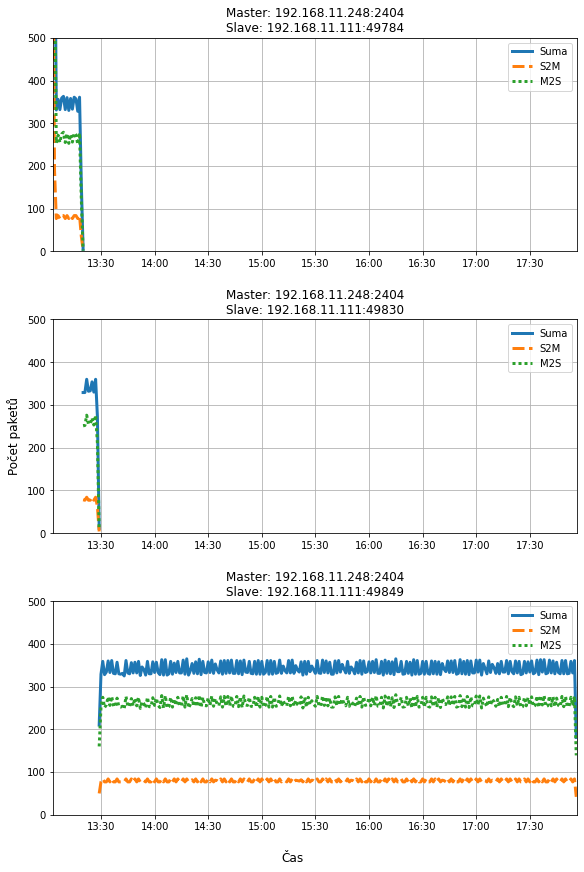

In [4]:
# dsa.get_df_time_span(df, fcn)

# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(1, 1, 1)

fig, axs = plt.subplots(3,1,figsize=(8, 12),constrained_layout = True)


# fig.tight_layout(w_pad=0, h_pad=4) 


start = df[fcn.timestamp].iloc[0]
end = df[fcn.timestamp].iloc[-1]

axs[0].set_xlim([start, end])
axs[1].set_xlim([start, end])
axs[2].set_xlim([start, end])

delta = datetime.timedelta(minutes=1)

# fig.axes.set_xlim([data.start_dt, data.end_dt])
plot_pair_flow(
    df, fcn, axs[0], 2, station_ids, direction_ids, delta
)

plot_pair_flow(
    df, fcn, axs[1], 0, station_ids, direction_ids, delta
)

plot_pair_flow(
    df, fcn, axs[2], 1, station_ids, direction_ids, delta
)


ylim = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1], axs[2].get_ylim()[1])

ylim = 500

axs[0].set_ylim([0, ylim])
axs[1].set_ylim([0, ylim])
axs[2].set_ylim([0, ylim])

axs[0].set_title("Master: 192.168.11.248:2404\nSlave: 192.168.11.111:49784")
axs[1].set_title("Master: 192.168.11.248:2404\nSlave: 192.168.11.111:49830")
axs[2].set_title("Master: 192.168.11.248:2404\nSlave: 192.168.11.111:49849")

axs[0].legend(['Suma','S2M', 'M2S'], loc='upper right')
axs[1].legend(['Suma','S2M', 'M2S'], loc='upper right')
axs[2].legend(['Suma','S2M', 'M2S'], loc='upper right')

fig.supxlabel("Čas")
fig.supylabel("Počet paketů")

# plt.subplots_adjust(left=0.1,
#                     bottom=0.01, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)

plt.plot()

plt.savefig('pgf/time_series.pgf')

In [5]:
df["oa"].value_counts()
station_ids

bidict({0: Station(ip='192.168.11.111', port=49784.0), 1: Station(ip='192.168.11.111', port=49830.0), 2: Station(ip='192.168.11.111', port=49849.0), 3: Station(ip='192.168.11.248', port=2404.0)})